# 신경망 학습

### 손실함수

오차제곱함(SSE)
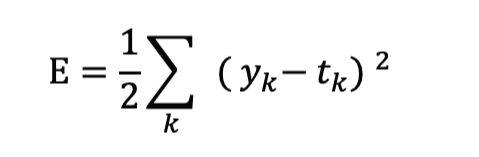

In [1]:
def sum_squares_error(y, t):
    return 0.5 * np.sum((y-t) ** 2)

교차 엔트로피(CEE)
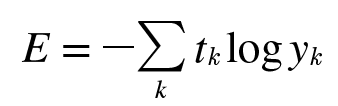

In [2]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

np.log() 함수에 0을 입력하면 -inf가 되어 아주 작은 값인 delta 값을 더합니다.

미니배치 학습<br>
가령 60,000장의 훈련 데이터 중 100장의 무작위로 뽑아 해당 100장만을 사용하여 학습하는 것.
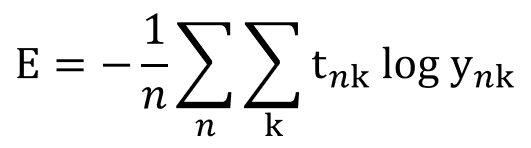

In [4]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [5]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

np.random.choice(x, y) 0이상 x미만의 수 중 무작위로 y개를 골라낸다.

중심 차분 / 중앙 차분 <br>
h = 1e-4, rounding error 방지하기 위한 좋은 값.

In [7]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2 * h)

기울기(gradient)<br>
모든 변수의 편미분을 벡터로 정리한 것.

In [12]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp.val = x[idx]
        
        # f(x+h) 계산
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad

경사법<br>
eta 기호는 learning rate를 뜻함.
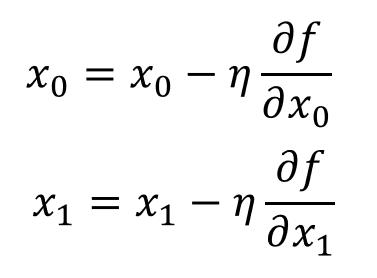

In [14]:
def gradient_descent(f, init_x, lr=0.01, step_num = 100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

In [ ]:
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

simpleNet - 형상이 2x3인 가중치 매개변수 하나를 인스턴스 변수로 갖음. <br>
predict(x)는 예측을 수행. <br>
loss(x, t)는 손실 함수의 값을 구한다.

### 4.5 학습 알고리즘 구현하기

1단계, 미니배치 <br>
훈련 데이터 중 일부를 무작위로 가져온다. <br>
2단계, 기울기 산출 <br>
미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구합니다. <br>
3단계, 매개변수 갱신 <br>
가중치 매개변수를 기울기 방향으로 아주 조금 갱신합니다. <br>
4단계, 1~3 반복 <br> <br>
이때 데이터를 미니배치로 무작위로 선정하기 때문에 확률적 경사법(SGD)라고 부릅니다.

In [ ]:
from common.functions import *

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

미니배치 학습 구현하기

In [ ]:
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

매번 60,000개의 훈련 데이터에서 임의로 100개의 데이터를 추려냅니다. <br>
그리고 100개의 미니배치를 대상으로 SGD를 수행해 매개변수를 갱신합니다. <br>
경사법에 의한 갱신 횟수(iters_num)을 10,000번으로 설정하고, 갱신할 때마다 훈련 데이터에 대한 손실 함수를 계산, 배열에 추가합니다.<br><br>

epoch - 1에폭은 학습에서 훈련 데이터를 모두 소진했을 때의 횟수입니다. <br>
훈련 데이터 10,000개, 100개의 미니배치로 학습할 경우 100회가 1에폭이 됩니다.